In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [55]:
data=pd.read_csv('after_data_cleaning.csv')

In [14]:
data=data.drop(['Unnamed: 0'],axis=1)
data.head()

,location,bath,price,BHK,total_sqft_clean,price_per_sqft
0,Electronic City Phase II,2.0,39.07,2,1056.0,3699.810606
1,Chikka Tirupathi,5.0,120.00,4,2600.0,4615.384615
2,Uttarahalli,2.0,62.00,3,1440.0,4305.555556
3,Lingadheeranahalli,3.0,95.00,3,1521.0,6245.890861
4,Kothanur,2.0,51.00,2,1200.0,4250.000000


In [15]:
len(data['location'].unique())

1304

In [16]:
categorical_columns = data.select_dtypes(include='object').columns
for x in categorical_columns:
    print(f'Number of classes in {x} : {data[x].nunique()}')

Number of classes in location : 1304


In [17]:
data['price_per_sqft'] = data['price']*100000/data['total_sqft_clean']
data.head()

,location,bath,price,BHK,total_sqft_clean,price_per_sqft
0,Electronic City Phase II,2.0,39.07,2,1056.0,3699.810606
1,Chikka Tirupathi,5.0,120.00,4,2600.0,4615.384615
2,Uttarahalli,2.0,62.00,3,1440.0,4305.555556
3,Lingadheeranahalli,3.0,95.00,3,1521.0,6245.890861
4,Kothanur,2.0,51.00,2,1200.0,4250.000000


checking location column

In [18]:
data['location'] = data['location'].apply(lambda x: x.strip())
location_stats = data.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
Thanisandra          236
                    ... 
LIC Colony             1
Kuvempu Layout         1
Kumbhena Agrahara      1
Kudlu Village,         1
1 Annasandrapalya      1
Name: location, Length: 1293, dtype: int64

In [19]:
locations_stats_less_than_10 = location_stats[location_stats<=10]
locations_stats_less_than_10

location
BTM 1st Stage          10
Basapura               10
Sector 1 HSR Layout    10
Naganathapura          10
Kalkere                10
                       ..
LIC Colony              1
Kuvempu Layout          1
Kumbhena Agrahara       1
Kudlu Village,          1
1 Annasandrapalya       1
Name: location, Length: 1052, dtype: int64

In [27]:
data['location'] = data['location'].apply(lambda x : "other" if x in locations_stats_less_than_10 else x)
len(data['location'].unique())

C:\Users\jaydip\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


242

In [28]:
# Per room sqft threshold be 300sqft: 
data = data[~(data.total_sqft_clean/data.BHK < 300)]
data.shape

(12498, 6)

In [29]:
data['price_per_sqft'].describe()

count     12498.000000
mean       6298.937463
std        4169.116547
min           2.257423
25%        4203.458878
50%        5291.005291
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

For normal distribution of data, we will keep price values which are near to mean and std. Outliers are all above mean+standard_deviation and below mean+standard_deviation.

In [30]:
# Function to remove outliers from price_per_sqft based on locations.
# As every location will have different price range.
def remove_price_outlier(data_in):
    data_out = pd.DataFrame()
    for key, subdf in data_in.groupby('location'):
        avg_price = np.mean(subdf.price_per_sqft)
        std_price = np.std(subdf.price_per_sqft)
        # data without outliers: 
        reduced_df = subdf[(subdf.price_per_sqft>(avg_price-std_price)) & (subdf.price_per_sqft<=(avg_price+std_price))]
        data_out =pd.concat([data_out, reduced_df], ignore_index=True)
    return data_out
data2 = remove_price_outlier(data)
data2.shape

(10268, 6)

It was found that in some rows price of 2BHK is very less than 1 BHK. So we will remove outliers based on BHK for each location. That is we can remove those n BHK apartments whose price_per_sqft is less than mean price_per_sqft of n-1 BHK.

In [37]:
def remove_bhk_outliers(data_in):
    exclude_indices = np.array([])
    for location, location_subdf in data_in.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_subdf in data_in.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean':np.mean(bhk_subdf.price_per_sqft),
                'std':np.std(bhk_subdf.price_per_sqft),
                'count':bhk_subdf.shape[0]
            }
        for bhk, bhk_subdf in location_subdf.groupby('BHK'):
            stats = bhk_stats.get(bhk-1) 
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_subdf[bhk_subdf.price_per_sqft<(stats['mean'])].index.values)
    return data_in.drop(exclude_indices, axis='index')
        
data3 = remove_bhk_outliers(data2)
data3.shape

(5361, 6)

Text(0, 0.5, 'Count')

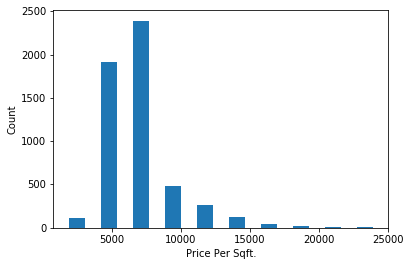

In [39]:
# Visualize to see number of data points for price_per_sqft
plt.hist(data3.price_per_sqft, rwidth=0.5)
plt.xlabel("Price Per Sqft.")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

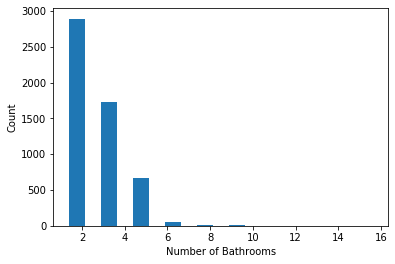

In [41]:
plt.hist(data3.bath, rwidth=0.5)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")

we cannot have (number of bathrooms) more than (number of bedrooms)+2

In [43]:
data3[data3.bath > data3.BHK+2]

,location,bath,price,BHK,total_sqft_clean,price_per_sqft
5252,Nagasandra,8.0,450.0,4,7000.0,6428.571429
6727,Thanisandra,6.0,116.0,3,1806.0,6423.034330
8431,other,9.0,1000.0,6,11338.0,8819.897689


In [44]:
# Remove bathroom outliers:
data4 = data3[data3.bath<data3.BHK+2]
data4.shape

(5293, 6)

Outliers removal is done. Now we can remove the extra column "price_per_sqft"

In [47]:
data5 = data4.drop(['price_per_sqft'], axis=1)
data5.head()

,location,bath,price,BHK,total_sqft_clean
0,1st Block Jayanagar,4.0,428.0,4,2850.0
1,1st Block Jayanagar,3.0,194.0,3,1630.0
2,1st Block Jayanagar,2.0,235.0,3,1875.0
3,1st Block Jayanagar,2.0,130.0,3,1200.0
4,1st Block Jayanagar,2.0,148.0,2,1235.0


As location variable is an categorical feature, we will create dummy columns for location feature using get dummies function.

In [49]:
location_dummies = pd.get_dummies(data5.location)
location_dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As this generated binary columns of locations, it is obvious that if any one the row value is 1 then rest are 0. So we will remove one column. Whenever there are N classes in a feature, we keep N-1 dummies for it. Here we will drop 'other' column

In [50]:
data6 = pd.concat([data5, location_dummies.drop('other', axis='columns')], axis='columns')
data6.head()

,location,bath,price,BHK,total_sqft_clean,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Varthur,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,1st Block Jayanagar,4.0,428.0,4,2850.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,3.0,194.0,3,1630.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,2.0,235.0,3,1875.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,2.0,130.0,3,1200.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,2.0,148.0,2,1235.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Remove Location Column:
data7 = data6.drop(['location'], axis='columns')
data7.head()

,bath,price,BHK,total_sqft_clean,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Varthur,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,4.0,428.0,4,2850.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,194.0,3,1630.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,235.0,3,1875.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,130.0,3,1200.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,148.0,2,1235.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
data7.shape

(5293, 223)

In [54]:
data7.to_csv('after_prepocessing.csv')